# For this workshop we will be using Keras to quickly prototype a working stock prediction model!

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from io import StringIO
import requests
import numpy as np
import pandas as pd
import time, math

np.set_printoptions(precision=4)

ticker = 'AAPL'

r = requests.get("https://finance.google.com/finance/historical?q=" + ticker + "&startdate=01-Jan-2008&output=csv")
stock = pd.read_csv(StringIO(r.text))

stock.head()

,Date,Open,High,Low,Close,Volume
0,2-Feb-18,166.00,166.80,160.10,160.50,86593825
1,1-Feb-18,167.16,168.62,166.76,167.78,47230787
2,31-Jan-18,166.87,168.44,166.50,167.43,32478930
3,30-Jan-18,165.52,167.37,164.70,166.97,46048185
4,29-Jan-18,170.16,170.16,167.07,167.96,50640406


# The Date Feature in time series serves as indexing

## For style purposes the column we are trying to predict is always the last one(s)

### Although here we are only predict closing price, recurrent neural networks are capable of predicting all the features in the dataset

* unlike a traditional classification problem, the target column we are trying to predict is located within the training set
* In the LSTM model, we are trying to use previous input sequences to try and predict future output sequences

In [20]:
stock.drop('Date', axis=1, inplace=True)

cols = stock.columns.tolist()
cols = cols[-1:] + cols[:-1]
stock = stock[cols]

stock.head()

,Volume,Open,High,Low,Close
0,86593825,166.00,166.80,160.10,160.50
1,47230787,167.16,168.62,166.76,167.78
2,32478930,166.87,168.44,166.50,167.43
3,46048185,165.52,167.37,164.70,166.97
4,50640406,170.16,170.16,167.07,167.96


# When using any algorithm that uses an activation function, your data must be normalized to values within the activation

## For using the ReLu function, you use min-max scaler (values between 0 and 1)

## For using the Tanh function, you use StandardScaler (values between -1 and 1)

In [4]:
# normalizaing data
# scale = MinMaxScaler(feature_range=(0,1)) # or StandardScaler
# #scale = StandardScaler()
# price = MinMaxScaler(feature_range=(0,1))
# price.fit(stock['Close'].reshape(-1,1))
# stock = pd.DataFrame(scale.fit_transform(stock), columns=['Volume', 
#                                                           'Open', 
#                                                           'High', 
#                                                           'Low', 
#                                                           'Close'])

d:\anaconda\envs\mangohacks\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


# Representing our data as a sequential model

## If we have data like

Volume | Open | High | Low | Close
--- | --- | --- | --- | ---
0.3106 | 0.1019 | 0.1004 | 0.0978 | 0.0991
0.2393 | 0.0987 | 0.0979 | 0.0979 | 0.0992
0.4237 | 0.0953 | 0.0942 | 0.0861 | 0.0866
0.3547 | 0.0436 | 0.0416 | 0.0388 | 0.0397

## suppose we choose to learn in sequences of 2 then our data will be represented like this

[0.3106 | 0.1019 | 0.1004 | 0.0978 | 0.0991

0.2393 | 0.0987 | 0.0979 | 0.0979 | 0.0992],

[0.2393 | 0.0987 | 0.0979 | 0.0979 | 0.0992

0.4237 | 0.0953 | 0.0942 | 0.0861 | 0.0866],

[0.4237 | 0.0953 | 0.0942 | 0.0861 | 0.0866

0.3547 | 0.0436 | 0.0416 | 0.0388 | 0.0397]

we'll create a new object which is 3x2x5, [amount_of_sequences, sequence_length, amount_of_features]


In [29]:
scalers = {}
prices = {}

def load_data(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        scalers[index] = MinMaxScaler(feature_range=(0,1))
        prices[index] = MinMaxScaler(feature_range=(0,1))
        
        prices[index].fit_transform(data[index: index + sequence_length][:, -1].reshape(-1,1))
        result.append(scalers[index].fit_transform(data[index: index + sequence_length]))
    
    result = np.array(result)
    row = len(result) * split
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    
    return [x_train, y_train, x_test, y_test]

# What is a Recurrent Neural Network?

![alt text](recurrent_cell.PNG "Title")

Unlike regular feed foward networks, the output of a layer in a recurrent neural network feeds back in on itself

![alt text](recurrent_network.PNG "Title")

The problem with recurrent neural networks however is that the weight update is a function that grows exponential, meaning that updating weights suffer from something known as vanishing gradient

![alt text](vanashing_RNN.PNG "Title")

Popularity of Recurrent Neural Networks has been resugring thanks to the invention of this new architecture

![alt text](LSTM_cell.PNG "Title")

LSTM solves the issue of vanishing gradients by making linear changes to the output C_t, while keeping the change within the hidden layer

In [30]:
window = 30 # Another hyperparameter

X_train, y_train, X_test, y_test = load_data(stock[::-1], window, 0.85)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2132, 30, 5)
y_train (2132,)
X_test (377, 30, 5)
y_test (377,)


In [23]:
def build_model(layers, dropout_rate, amount_of_layers):
    model = Sequential()

    for x in range(0,amount_of_layers):
        model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(layers[2], return_sequences=False)) 
    model.add(Dropout(dropout_rate))

    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("relu"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [24]:
model = build_model([5, window, 1], 0.2, 3)

d:\anaconda\envs\mangohacks\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
d:\anaconda\envs\mangohacks\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=30)`
  """


Compilation Time :  0.037776947021484375


d:\anaconda\envs\mangohacks\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # This is added back by InteractiveShellApp.init_path()


In [25]:
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_split=0.1, verbose=1)

Train on 1918 samples, validate on 214 samples
Epoch 1/100
1918/1918 [==============================] - 5s 3ms/step - loss: 0.4053 - acc: 0.0532 - val_loss: 0.1987 - val_acc: 0.0794
Epoch 2/100
1918/1918 [==============================] - 1s 418us/step - loss: 0.2678 - acc: 0.0532 - val_loss: 0.1588 - val_acc: 0.0794
Epoch 3/100
1918/1918 [==============================] - 1s 365us/step - loss: 0.2301 - acc: 0.0532 - val_loss: 0.1350 - val_acc: 0.0794
Epoch 4/100
1918/1918 [==============================] - 1s 366us/step - loss: 0.1966 - acc: 0.0766 - val_loss: 0.1219 - val_acc: 0.0794
Epoch 5/100
1918/1918 [==============================] - 1s 385us/step - loss: 0.1965 - acc: 0.1319 - val_loss: 0.1183 - val_acc: 0.0794
Epoch 6/100
1918/1918 [==============================] - 1s 374us/step - loss: 0.1801 - acc: 0.1455 - val_loss: 0.1173 - val_acc: 0.0794
Epoch 7/100
1918/1918 [==============================] - 1s 366us/step - loss: 0.1897 - acc: 0.1429 - val_loss: 0.1170 - val_acc: 0.0

1918/1918 [==============================] - 1s 377us/step - loss: 0.0870 - acc: 0.1840 - val_loss: 0.0357 - val_acc: 0.1776
Epoch 61/100
1918/1918 [==============================] - 1s 374us/step - loss: 0.0844 - acc: 0.1851 - val_loss: 0.0344 - val_acc: 0.1776
Epoch 62/100
1918/1918 [==============================] - 1s 365us/step - loss: 0.0799 - acc: 0.1846 - val_loss: 0.0318 - val_acc: 0.1822
Epoch 63/100
1918/1918 [==============================] - 1s 373us/step - loss: 0.0836 - acc: 0.1804 - val_loss: 0.0330 - val_acc: 0.1822
Epoch 64/100
1918/1918 [==============================] - 1s 366us/step - loss: 0.0803 - acc: 0.1840 - val_loss: 0.0325 - val_acc: 0.1822
Epoch 65/100
1918/1918 [==============================] - 1s 357us/step - loss: 0.0816 - acc: 0.1804 - val_loss: 0.0319 - val_acc: 0.1822
Epoch 66/100
1918/1918 [==============================] - 1s 367us/step - loss: 0.0805 - acc: 0.1830 - val_loss: 0.0330 - val_acc: 0.1822
Epoch 67/100
1918/1918 [=======================

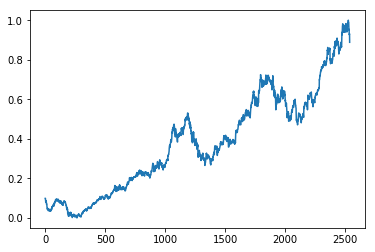

In [13]:
import matplotlib.pyplot as plt

plt.plot(stock['Close'][::-1].reset_index()['Close'])

plt.show()

In [26]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.03 MSE (0.18 RMSE)
Test Score: 0.03 MSE (0.16 RMSE)


In [27]:
pred = model.predict(X_test)

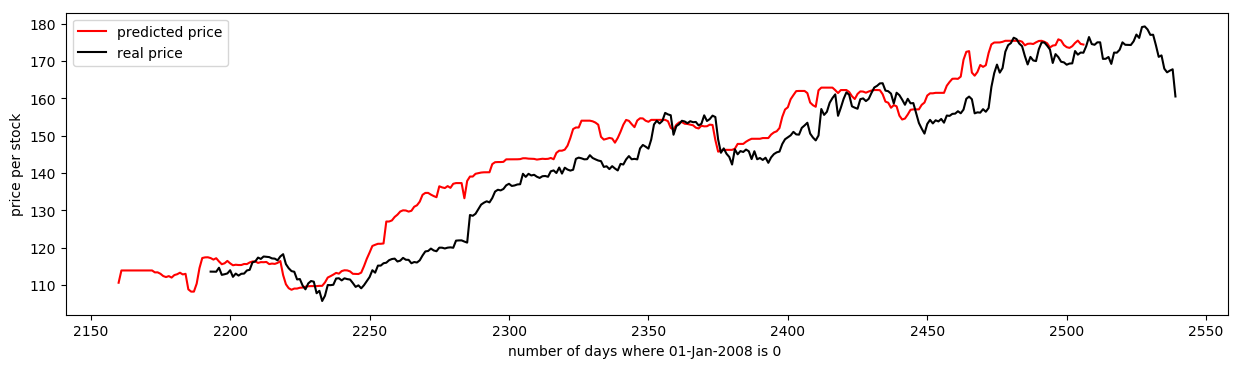

In [35]:
plt.figure(figsize=(15,4), dpi=100)

results = []
pred_results = []
counter = 0

for x in np.arange(2160, 2507, 1): #2160, 2161, ..., 2507
    results = results + [prices[x].inverse_transform(pred[counter: counter + 30]).reshape(-1,1)[0]]
    counter = counter + 1


plt.plot(np.arange(2160, 2507, 1),results, color='red', label='predicted price')
plt.plot(stock['Close'][::-1].reset_index()['Close'][-347:], color='black', label='real price')


plt.xlabel('number of days where 01-Jan-2008 is 0 ')
plt.ylabel('price per stock')
plt.legend(loc='upper left')
plt.show()